# Setup

In [1]:
# Pandas and numpy necessary to do basic data cleaning
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt

In [50]:
def gen_data(N, T, cohorts, effects, baseline, i_fe_scale, t_fe_scale, t_fe_trend, u0_scale, u1_scale):
    
    # Set seed
    np.random.seed(5882300)

    # Combine people into dataset 
    ids    = np.tile(np.arange(1,N+1),T)
    time   = np.repeat(np.arange(1,T+1),N)
    cdf    = pd.DataFrame({'id':np.arange(1,N+1),'cohort':cohorts})
    df     = pd.DataFrame({'id':ids,'time':time})
    df     = df.merge(cdf, on='id', how='inner')

    # Add relative time and treatment indicator
    df['rel'] = df.time - df.cohort
    df['D']   = (df.rel >= 0).astype(int)

    # Add random person fixed effects and linear time trend.
    i_fe    = np.random.uniform(size=N) * i_fe_scale
    t_fe    = t_fe_trend + np.random.normal(loc=0.0,scale=t_fe_scale,size=T)
    i_fe_df = pd.DataFrame({'id':np.arange(1,N+1),'i_fe':i_fe})
    t_fe_df = pd.DataFrame({'time':np.arange(1,T+1),'t_fe':t_fe})
    df      = df.merge(i_fe_df, on='id', how='inner')
    df      = df.merge(t_fe_df, on='time', how='inner')

    # Random noise
    df['u0'] = np.random.normal(size=N*T, loc=0.0, scale=u0_scale)
    df['u1'] = np.random.normal(size=N*T, loc=0.0, scale=u1_scale)

    # Potential outcomes model
    df        = df.sort_values(['id','time'])
    df['att'] = effects
    df['y0']  = baseline + df.t_fe + df.i_fe + df.u0
    df['y1']  = baseline + df.t_fe + df.i_fe + df.att + df.u1
    df['y']   = df.D*(df.y1) + (1.0-df.D)*(df.y0)

    # Average by cohort
    agg_df = df.groupby(['cohort','time']).mean().reset_index()
    
    return df, agg_df

# 7(a) - Common Trends in Linear vs. Log

In [59]:
# DGP parameters
N          = 2    # Sample size
T          = 15   # Time periods
i_fe_scale = 8.0 # Individual fixed effects ~ Unif[0, i_fe_scale]
t_fe_scale = 0.0  # Time fixed effects = specified below + N(0, t_fe_scale)
u0_scale   = 0.0  # Variance of noise term added to Y(0)
u1_scale   = 0.0  # Variance of noise term added to Y(1)
baseline   = 5.0  # Baseline level of potential outcome

# How things change over time
t_fe_trend = np.arange(1,T+1)-5

# Cohorts
cohorts = np.array([10, 50])

# Treatment effects
effects = np.repeat(1.0, N*T)

# Get data 
df,agg_df = gen_data(N, T, cohorts, effects, baseline, i_fe_scale, t_fe_scale, t_fe_trend, u0_scale, u1_scale)

# Take logs
df['ln_y0'] = np.log(df.y0)
df['ln_y1'] = np.log(df.y1)
df['ln_y']  = np.log(df.y)

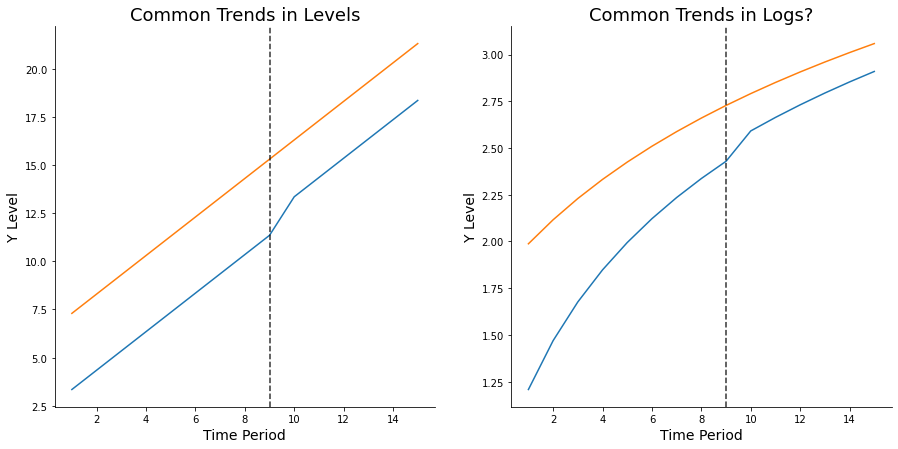

In [60]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
ax     = ax.flatten()

# Formatting stuff
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# Plot 1 main stuff
ax[0].plot(df.loc[df.id == 1, 'time'], df.loc[df.id == 1, 'y'])
ax[0].plot(df.loc[df.id == 2, 'time'], df.loc[df.id == 2, 'y'])
ax[1].plot(df.loc[df.id == 1, 'time'], df.loc[df.id == 1, 'ln_y'])
ax[1].plot(df.loc[df.id == 2, 'time'], df.loc[df.id == 2, 'ln_y'])

# Vertical/horizontal lines
ax[0].axvline(x=9, color='black', linestyle='dashed', alpha=0.8)
ax[1].axvline(x=9, color='black', linestyle='dashed', alpha=0.8)

# Axis mess
ax[0].set_xlabel("Time Period", size=14)
ax[0].set_ylabel("Y Level", size=14)
ax[1].set_xlabel("Time Period", size=14)
ax[1].set_ylabel("Y Level", size=14)

# Titles
ax[0].set_title("Common Trends in Levels", size=18)
ax[1].set_title("Common Trends in Logs?", size=18)

# Save out
plt.savefig("./q7_output/q7a.png")
plt.show()

# 7(b)

In [63]:
# DGP parameters
N          = 300  # Sample size
T          = 30   # Time periods
i_fe_scale = 5.0  # Individual fixed effects ~ Unif[0, i_fe_scale]
t_fe_scale = 0.0  # Time fixed effects = specified below + N(0, t_fe_scale)
u0_scale   = 1.0  # Variance of noise term added to Y(0)
u1_scale   = 1.0  # Variance of noise term added to Y(1)
baseline   = 2.0 

# How things change over time
t_fe_trend = np.arange(1,T+1) 

# Cohorts
cohorts = np.concatenate((np.repeat(5, 150), 
                          np.repeat(9, 100), 
                          np.repeat(22, 50)))

# Treatment effects
effects = np.concatenate((np.tile(np.arange(1,T+1)*3.0,150), 
                          np.tile(np.arange(1,T+1)*1.0,100), 
                          np.tile(np.arange(1,T+1)*0.5,50)))

# Get data 
df,agg_df = gen_data(N, T, cohorts, effects, baseline, i_fe_scale, t_fe_scale, t_fe_trend, u0_scale, u1_scale)

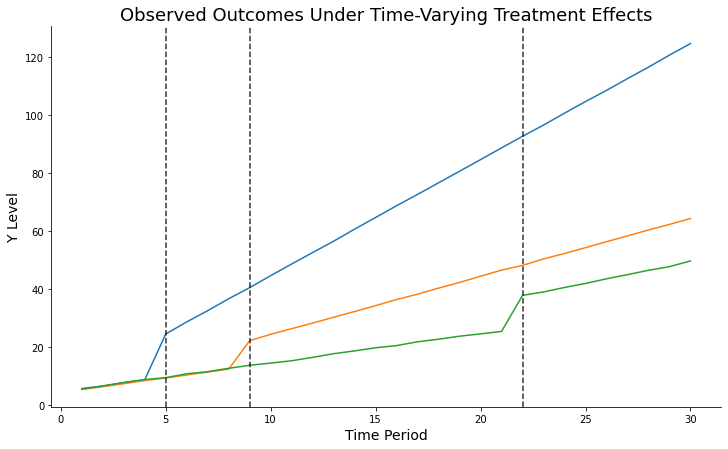

In [64]:
fig,ax = plt.subplots(figsize=(12,7))

# Formatting stuff
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot 1 main stuff
ax.plot(agg_df.loc[agg_df.cohort == 5, 'time'], agg_df.loc[agg_df.cohort == 5, 'y'])
ax.plot(agg_df.loc[agg_df.cohort == 9, 'time'], agg_df.loc[agg_df.cohort == 9, 'y'])
ax.plot(agg_df.loc[agg_df.cohort == 22, 'time'], agg_df.loc[agg_df.cohort == 22, 'y'])

# Vertical/horizontal lines
ax.axvline(x=5, color='black', linestyle='dashed', alpha=0.8)
ax.axvline(x=9, color='black', linestyle='dashed', alpha=0.8)
ax.axvline(x=22, color='black', linestyle='dashed', alpha=0.8)

# Axis mess
ax.set_xlabel("Time Period", size=14)
ax.set_ylabel("Y Level", size=14)

# Titles
ax.set_title("Observed Outcomes Under Time-Varying Treatment Effects", size=18)

# Save out
plt.savefig("./q7_output/q7b.png")
plt.show()

In [65]:
# Build regression df
reg_df            = copy.deepcopy(df)
reg_df['_const']  = 1.0
unit_dummies      = pd.get_dummies(df['id'])
time_dummies      = pd.get_dummies(df['time'])
unit_cols         = [f'i: {col}' for col in unit_dummies.columns]
time_cols         = [f't: {col}' for col in time_dummies.columns]
reg_df[unit_cols] = unit_dummies
reg_df[time_cols] = time_dummies

# Get regression matrices
X = np.array(reg_df[['D','_const']+unit_cols[:-1]+time_cols[:-1]])
y = np.array(reg_df['y'])[:,None]

# Get regression results
beta    = (np.linalg.inv(X.T @ X) @ X.T @ y)[0:2]
beta_df = pd.DataFrame({"Coefficient":["ATT Estimate","Intercept"], "Value":beta.ravel()})
beta_df.to_latex("./q7_output/q7b_table.tex", index=False)

In [66]:
beta_df

,Coefficient,Value
0,ATT Estimate,-5.147657
1,Intercept,72.607252


# 7(c)

In [68]:
# DGP parameters
N          = 900  # Sample size
T          = 10   # Time periods
i_fe_scale = 0.0  # Individual fixed effects ~ Unif[0, i_fe_scale]
t_fe_scale = 0.0  # Time fixed effects = specified below + N(0, t_fe_scale)
u0_scale   = 0.0  # Variance of noise term added to Y(0)
u1_scale   = 0.0  # Variance of noise term added to Y(1)
baseline   = 2.0 

# How things change over time
t_fe_trend = np.arange(1,T+1) 

# Cohorts
cohorts = np.concatenate((np.repeat(4, int(N/3)), 
                          np.repeat(5, int(N/3)), 
                          np.repeat(6, int(N/3))))

# Treatment effects - homogeneous
effects1 = np.concatenate((np.tile(np.repeat(10.0,T), int(N/3)), 
                           np.tile(np.repeat(10.0,T), int(N/3)), 
                           np.tile(np.repeat(10.0,T), int(N/3))))

# Treatment effects - heterogeneous
effects2 = np.concatenate((np.tile(np.repeat(20.0,T), int(N/3)), 
                           np.tile(np.repeat(10.0,T), int(N/3)), 
                           np.tile(np.repeat(0.0,T), int(N/3))))

# Get data 
df1,agg_df1 = gen_data(N, T, cohorts, effects1, baseline, i_fe_scale, t_fe_scale, t_fe_trend, u0_scale, u1_scale)
df2,agg_df2 = gen_data(N, T, cohorts, effects2, baseline, i_fe_scale, t_fe_scale, t_fe_trend, u0_scale, u1_scale)

In [75]:
# Build regression dfs
dfs      = [df1,df2]
beta_dfs = []
for i in range(len(dfs)):
    
    reg_df               = dfs[i].copy()
    reg_df['_const']     = 1.0
    
    # Make unit dummies, time dummies, relative time dummies
    unit_dummies         = pd.get_dummies(dfs[i]['id'])
    time_dummies         = pd.get_dummies(dfs[i]['time'])
    reltime_dummies      = pd.get_dummies(dfs[i]['rel'])
    unit_cols            = [f'i: {col}' for col in unit_dummies.columns if col != 1]
    time_cols            = [f't: {col}' for col in time_dummies.columns if col != 1]
    reltime_cols         = [f'r: {col}' for col in reltime_dummies.columns if ((col != -1) & (col != 6))]
    reg_df[unit_cols]    = unit_dummies.drop(1, axis=1)
    reg_df[time_cols]    = time_dummies.drop(1, axis=1)
    reg_df[reltime_cols] = reltime_dummies.drop([-1,6], axis=1)
        
    # Get regression matrices
    X = np.array(reg_df[reltime_cols + unit_cols + time_cols + ['_const']])
    y = np.array(reg_df['y'])[:,None]
    
    # Get regression results
    beta    = (np.linalg.inv(X.T @ X) @ X.T @ y).ravel()
    beta_df = pd.DataFrame({"Coefficient": reltime_cols, 
                            "Value": beta[0:len(reltime_cols)]})
    print(beta_df)
    beta_dfs.append(beta_df)

  Coefficient     Value
0       r: -5  5.714286
1       r: -4  4.285714
2       r: -3  2.857143
3       r: -2  1.428571
4        r: 0  8.571429
5        r: 1  7.142857
6        r: 2  5.714286
7        r: 3  4.285714
8        r: 4  2.857143
9        r: 5  1.428571
  Coefficient      Value
0       r: -5  40.847718
1       r: -4  30.571403
2       r: -3  20.063429
3       r: -2   9.195025
4        r: 0   4.471890
5        r: 1   2.602741
6        r: 2   2.430831
7        r: 3   1.811004
8        r: 4   1.285608
9        r: 5   0.830404


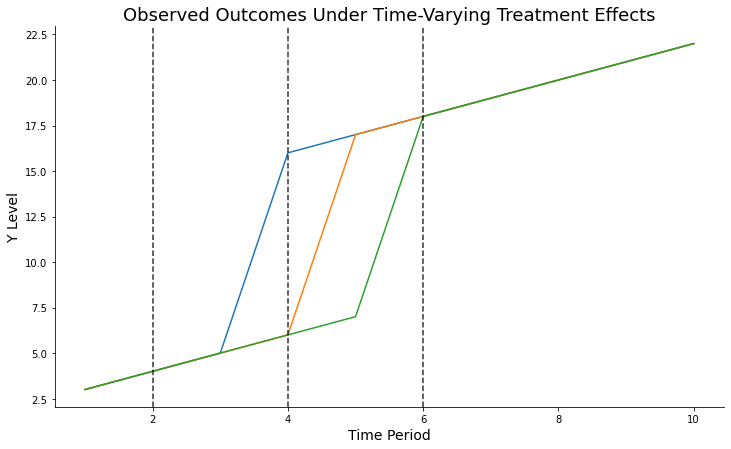

In [76]:
fig,ax = plt.subplots(figsize=(12,7))

# Formatting stuff
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot 1 main stuff
ax.plot(agg_df1.loc[agg_df1.cohort == 4, 'time'], agg_df1.loc[agg_df1.cohort == 4, 'y'])
ax.plot(agg_df1.loc[agg_df1.cohort == 5, 'time'], agg_df1.loc[agg_df1.cohort == 5, 'y'])
ax.plot(agg_df1.loc[agg_df1.cohort == 6, 'time'], agg_df1.loc[agg_df1.cohort == 6, 'y'])

# Vertical/horizontal lines
ax.axvline(x=2, color='black', linestyle='dashed', alpha=0.8)
ax.axvline(x=4, color='black', linestyle='dashed', alpha=0.8)
ax.axvline(x=6, color='black', linestyle='dashed', alpha=0.8)

# Axis mess
ax.set_xlabel("Time Period", size=14)
ax.set_ylabel("Y Level", size=14)

# Titles
ax.set_title("Observed Outcomes Under Time-Varying Treatment Effects", size=18)

# Save out
plt.savefig("./q7_output/q7c.png")
plt.show()

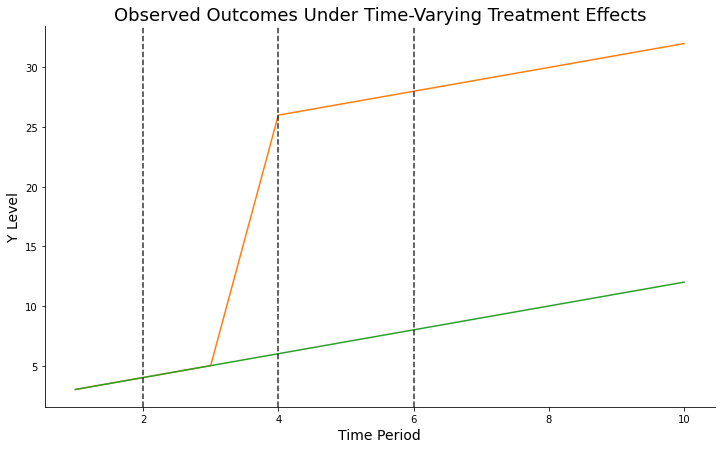

In [77]:
fig,ax = plt.subplots(figsize=(12,7))

# Formatting stuff
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot 1 main stuff
ax.plot(agg_df2.loc[agg_df2.cohort == 2, 'time'], agg_df2.loc[agg_df2.cohort == 2, 'y'])
ax.plot(agg_df2.loc[agg_df2.cohort == 4, 'time'], agg_df2.loc[agg_df2.cohort == 4, 'y'])
ax.plot(agg_df2.loc[agg_df2.cohort == 6, 'time'], agg_df2.loc[agg_df2.cohort == 6, 'y'])

# Vertical/horizontal lines
ax.axvline(x=2, color='black', linestyle='dashed', alpha=0.8)
ax.axvline(x=4, color='black', linestyle='dashed', alpha=0.8)
ax.axvline(x=6, color='black', linestyle='dashed', alpha=0.8)

# Axis mess
ax.set_xlabel("Time Period", size=14)
ax.set_ylabel("Y Level", size=14)

# Titles
ax.set_title("Observed Outcomes Under Time-Varying Treatment Effects", size=18)

# Save out
plt.savefig("./q7_output/q7c.png")
plt.show()